In [ ]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("NASA Web Logs Analysis") \
    .getOrCreate()

# Print Spark version
print(f"Spark Version: {spark.version}")


Spark Version: 3.5.4


In [ ]:
log_file_path = "access_log_Aug95"
raw_data = spark.read.text(log_file_path)
raw_data.show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839|
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                   |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                          |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0                           |


In [ ]:
from pyspark.sql.functions import regexp_extract

# Regular expressions for parsing
host_pattern = r'^(\S+)'  # Extracts host
timestamp_pattern = r'\[(.*?)\]'  # Extracts timestamp
method_endpoint_pattern = r'\"(GET|POST|HEAD|PUT|DELETE)\s(\S+)\s'  # Extracts HTTP method and endpoint
status_pattern = r'(\d{3})'  # Extracts status code
content_size_pattern = r'(\d+)$'  # Extracts content size

# Parse data into structured columns
logs_df = raw_data.withColumn("host", regexp_extract("value", host_pattern, 1)) \
                  .withColumn("timestamp", regexp_extract("value", timestamp_pattern, 1)) \
                  .withColumn("endpoint", regexp_extract("value", method_endpoint_pattern, 2)) \
                  .withColumn("status", regexp_extract("value", status_pattern, 1).cast("int")) \
                  .withColumn("content_size", regexp_extract("value", content_size_pattern, 1).cast("int"))
logs_df.show(5)


+--------------------+-----------------+--------------------+--------------------+------+------------+
|               value|             host|           timestamp|            endpoint|status|content_size|
+--------------------+-----------------+--------------------+--------------------+------+------------+
|in24.inetnebr.com...|in24.inetnebr.com|01/Aug/1995:00:00...|/shuttle/missions...|   199|        1839|
|uplherc.upl.com -...|  uplherc.upl.com|01/Aug/1995:00:00...|                   /|   199|           0|
|uplherc.upl.com -...|  uplherc.upl.com|01/Aug/1995:00:00...|/images/ksclogo-m...|   199|           0|
|uplherc.upl.com -...|  uplherc.upl.com|01/Aug/1995:00:00...|/images/MOSAIC-lo...|   199|           0|
|uplherc.upl.com -...|  uplherc.upl.com|01/Aug/1995:00:00...|/images/USA-logos...|   199|           0|
+--------------------+-----------------+--------------------+--------------------+------+------------+
only showing top 5 rows



In [ ]:
#a
logs_df.selectExpr(
    "AVG(content_size) as avg_size",
    "MIN(content_size) as min_size",
    "MAX(content_size) as max_size"
).show()


+----------------+--------+--------+
|        avg_size|min_size|max_size|
+----------------+--------+--------+
|17244.9678759674|       0| 3421948|
+----------------+--------+--------+



In [ ]:
#b
logs_df.groupBy("status").count().orderBy("status").show()


+------+-----+
|status|count|
+------+-----+
|     0| 1602|
|     1| 2414|
|     2| 3157|
|     3| 2152|
|     4| 2671|
|     5| 1943|
|     6| 2207|
|     7| 2129|
|     8| 1690|
|     9| 2067|
|    10| 2473|
|    11| 2202|
|    12| 2909|
|    13| 2231|
|    14| 2178|
|    15| 1851|
|    16| 1911|
|    17| 2014|
|    18| 1493|
|    19| 1202|
+------+-----+
only showing top 20 rows



In [ ]:
# c
from pyspark.sql.functions import desc

logs_df.groupBy("host").count().orderBy(desc("count")).limit(10).show()


+--------------------+-----+
|                host|count|
+--------------------+-----+
|  edams.ksc.nasa.gov| 6530|
|piweba4y.prodigy.com| 4846|
|        163.206.89.4| 4791|
|piweba5y.prodigy.com| 4607|
|piweba3y.prodigy.com| 4416|
|www-d1.proxy.aol.com| 3889|
|www-b2.proxy.aol.com| 3534|
|www-b3.proxy.aol.com| 3463|
|www-c5.proxy.aol.com| 3423|
|www-b5.proxy.aol.com| 3411|
+--------------------+-----+



In [ ]:
#d
logs_df.groupBy("endpoint").count().orderBy(desc("count")).limit(20).show()


+--------------------+-----+
|            endpoint|count|
+--------------------+-----+
|/images/NASA-logo...|97293|
|/images/KSC-logos...|75283|
|/images/MOSAIC-lo...|67356|
|/images/USA-logos...|66975|
|/images/WORLD-log...|66351|
|/images/ksclogo-m...|62670|
|           /ksc.html|43619|
|/history/apollo/i...|37806|
|/images/launch-lo...|35119|
|                   /|30123|
|/images/ksclogosm...|27789|
|/shuttle/missions...|24592|
| /shuttle/countdown/|24445|
|/shuttle/missions...|24363|
|/shuttle/missions...|23391|
|/shuttle/missions...|22429|
|/images/launchmed...|19863|
|  /htbin/cdt_main.pl|17238|
|/shuttle/countdow...|12154|
|     /icons/menu.xbm|12128|
+--------------------+-----+



In [ ]:
# e
logs_df.filter("status >= 400").groupBy("endpoint").count().orderBy(desc("count")).limit(10).show()


+--------------------+-----+
|            endpoint|count|
+--------------------+-----+
|/images/NASA-logo...| 2287|
|/images/MOSAIC-lo...| 1465|
|/images/WORLD-log...| 1458|
|/images/USA-logos...| 1456|
|/images/ksclogo-m...| 1425|
|           /ksc.html| 1229|
|/images/KSC-logos...| 1109|
|  /htbin/cdt_main.pl|  598|
|/history/apollo/i...|  589|
|/shuttle/countdow...|  545|
+--------------------+-----+



In [ ]:
# f
unique_hosts = logs_df.select("host").distinct().count()
print(f"Unique hosts: {unique_hosts}")


Unique hosts: 75060


In [ ]:
# g
total_requests = logs_df.count()
avg_requests_per_host = total_requests / unique_hosts
print(f"Average requests per host: {avg_requests_per_host}")


Average requests per host: 20.915241140420996


In [ ]:
# h
logs_df.filter("status == 404").groupBy("endpoint").count().orderBy(desc("count")).limit(20).show()


+--------------------+-----+
|            endpoint|count|
+--------------------+-----+
|/images/NASA-logo...|    6|
|/images/KSC-logos...|    5|
|/images/USA-logos...|    5|
|/images/MOSAIC-lo...|    5|
|/images/WORLD-log...|    5|
|/images/ksclogo-m...|    4|
|           /ksc.html|    3|
|/history/early-as...|    2|
|/shuttle/missions...|    2|
|/images/launchmed...|    2|
|/cgi-bin/imagemap...|    1|
|  /htbin/cdt_main.pl|    1|
|/shuttle/missions...|    1|
|/cgi-bin/imagemap...|    1|
|/shuttle/countdow...|    1|
|/history/rocket-h...|    1|
|                   /|    1|
|/shuttle/missions...|    1|
| /shuttle/countdown/|    1|
|/history/history....|    1|
+--------------------+-----+



In [ ]:
# i
logs_df.filter("status == 404").groupBy("host").count().orderBy(desc("count")).limit(20).show()


+--------------------+-----+
|                host|count|
+--------------------+-----+
| slip4048.sirius.com|   18|
|  ss4040.den.mmc.com|   16|
|tempnam_404.kentl...|    8|
|      s40416.esu.edu|    6|
| slip4044.sirius.com|    4|
|  grail404.nando.net|    4|
| job404a.bradley.edu|    4|
+--------------------+-----+



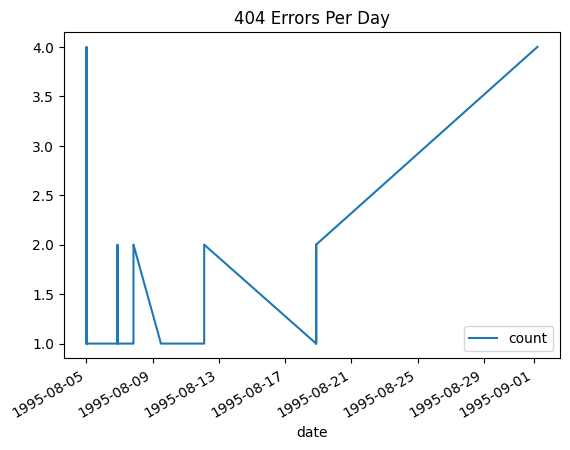

In [ ]:
# j
'''from pyspark.sql.functions import to_date

daily_404 = logs_df.filter("status == 404").withColumn("date", to_date("timestamp", "dd/MMM/yyyy")) \
                   .groupBy("date").count().toPandas()

import matplotlib.pyplot as plt

daily_404.plot(x="date", y="count", kind="line", title="404 Errors Per Day")
plt.show()
'''
from pyspark.sql.functions import to_timestamp

# Set legacy parser policy if needed
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Correct timestamp parsing
correct_format = "dd/MMM/yyyy:HH:mm:ss Z"
daily_404 = logs_df.filter("status == 404") \
    .withColumn("date", to_timestamp("timestamp", correct_format)) \
    .groupBy("date").count().toPandas()

import matplotlib.pyplot as plt

# Plot the result
daily_404.plot(x="date", y="count", kind="line", title="404 Errors Per Day")
plt.show()


In [ ]:
# k
logs_df.filter("status == 404").withColumn("date", to_date("timestamp", "dd/MMM/yyyy")) \
    .groupBy("date").count().orderBy(desc("count")).limit(3).show()


+----------+-----+
|      date|count|
+----------+-----+
|1995-08-04|   16|
|1995-08-06|   12|
|1995-08-11|   10|
+----------+-----+



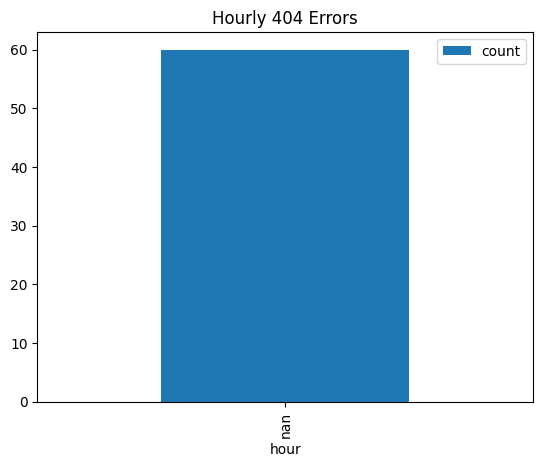

In [ ]:
# l
from pyspark.sql.functions import hour

hourly_404 = logs_df.filter("status == 404").withColumn("hour", hour("timestamp")) \
                    .groupBy("hour").count().toPandas()

hourly_404.plot(x="hour", y="count", kind="bar", title="Hourly 404 Errors")
plt.show()
